In [1]:
%load_ext autoreload
%autoreload 2

### Imports

Internal imports

In [2]:
# Find ".env" file and add the package to $PATH
import os, sys
import typing as t
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv()))
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "platform"

# Use local package for modularity
import emotion_analysis as ea
import emotion_analysis.data.dataset as data
from emotion_analysis.model.emotion_cause_text import load_text_model
from emotion_analysis.data.transform import DataTokenize, DataTransform

JAX Backend:  gpu
JAX Version:  0.4.23
Python:  3.11.0 (main, Oct  4 2023, 22:00:02) [GCC 13.2.1 20230801]
System:  posix.uname_result(sysname='Linux', nodename='archlinux', release='6.6.8-arch1-1', version='#1 SMP PREEMPT_DYNAMIC Thu, 21 Dec 2023 19:01:01 +0000', machine='x86_64')


External Imports

In [3]:
import mlflow
import re
import jax
import jax.numpy as jnp
import jax.random as rng
import optax as opt
import numpy as np
import pandas as pd
import dataclasses
import seaborn as sea
import wordcloud as wc
import matplotlib as mpl
import matplotlib.pyplot as plt
from transformers import RobertaTokenizerFast, BatchEncoding
from datasets import Dataset, Features, Value, ClassLabel

### Utils

Setup presentation

In [4]:
sea.set_theme('notebook', style='whitegrid')

Utilities

In [22]:
# Dataset options
max_conv_len = 24
max_uttr_len = 50

# Load tokenizer
tokenizer = load_text_model().tokenizer
tokenizer = DataTokenize(tokenizer, max_length=max_uttr_len, padding='max_length')
transform = DataTransform(tokenizer, max_length=max_conv_len)

# Load dataset
dataset = data.ECACDataset(task='task_1',
                           split='test',
                           batch_size=40,
                           filter_data=False,
                           transform=transform,
                           data_dir=ea.DATA_DIR,
                           max_utterance_len=40,
                           max_conversation_len=max_conv_len)

batch: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


In [23]:
# Load tokenizer
tokenizer = load_text_model().tokenizer
tokenizer = DataTokenize(tokenizer, max_length=None, padding='longest')
data_copy = dataset.data.metadata.conversation.copy(True)
data_copy['input_ids'] = data_copy['text'].apply(lambda x: tokenizer(x).data['input_ids'][0])

### Data Analysis

#### Analyze conversation length distribution

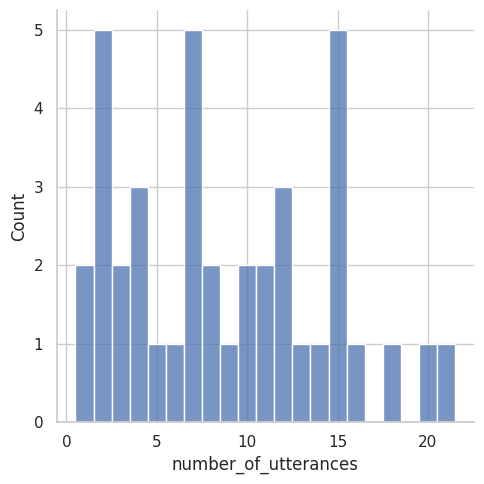

In [24]:
# Get number of utterances per conversation
conversation_lengths = data_copy['conversation_id'] \
    .value_counts(sort=False) \
    .rename('number_of_utterances') \
    .reset_index()

sea.displot(conversation_lengths, discrete=True, kind='hist', x='number_of_utterances')

#### Analyze Utterence Length Distribution in Terms of `token_ids`

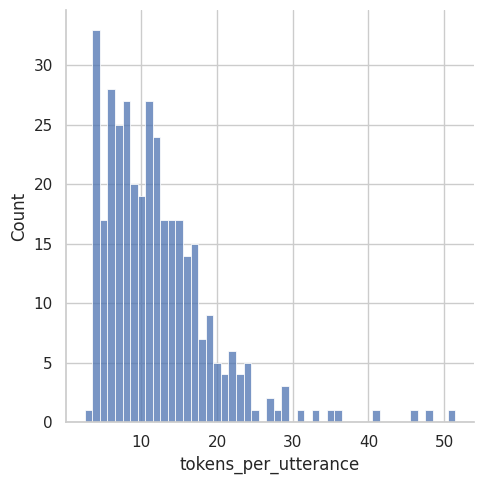

In [25]:
# Get number of token_id count per utterance
utterance_lengths = data_copy['input_ids'] \
    .apply(lambda x: len(x)) \
    .rename('tokens_per_utterance') \
    .reset_index(drop=True) \
    .to_frame()

sea.displot(utterance_lengths, discrete=True, kind='hist', x='tokens_per_utterance')

#### Analyze Utterance Length Distribution in Terms of `units`

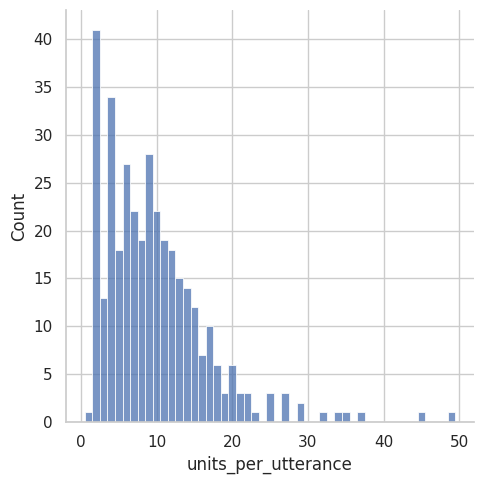

In [26]:
# Get number of token_id count per utterance
utterance_lengths = data_copy['text'] \
    .apply(lambda x: len(x.split(' '))) \
    .rename('units_per_utterance') \
    .reset_index(drop=True) \
    .to_frame()

sea.displot(utterance_lengths, discrete=True, kind='hist', x='units_per_utterance')

#### Analyze how many `utterances` are per-emotion

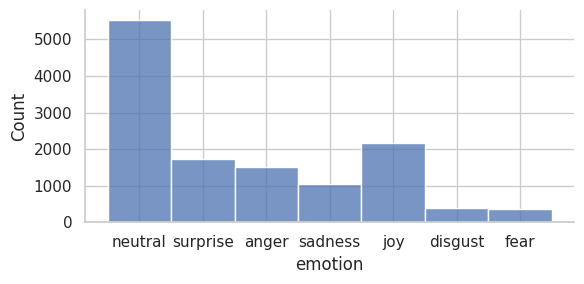

In [15]:
data_copy['emotion'] = data_copy['emotion'].map(dataset.class_to_emotion)
sea.displot(data=data_copy, x='emotion', bins=7, kind='hist', aspect=2, height=3)

#### Analyze the most `frequent words` per-emotion

In [16]:
emotion_text = data_copy.groupby('emotion')[['text']].agg(lambda x: ' '.join(x))
emotion_text

,text
emotion,
anger,"That is right . Yeah , well , you did not know..."
disgust,"Nooo ... It is worse than the thumb ! I mean ,..."
fear,"Nuh ... uh . Janice . Oh yeah , and what would..."
joy,"That is one way ! Oh , look , wish me luck ! I..."
neutral,"Alright , so I am back in high school , I am s..."
sadness,"I do not want to be single , okay ? I just ......"
surprise,"Then I look down , and I realize there is a ph..."


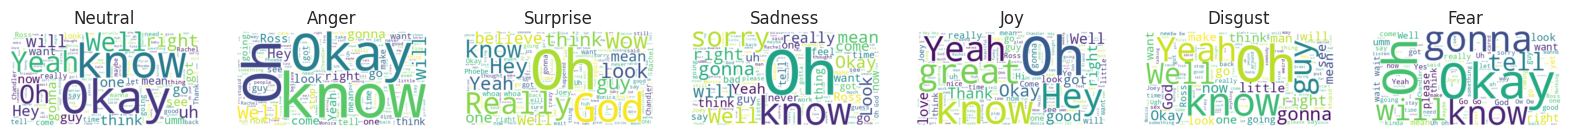

In [17]:
fig, axis = plt.subplots(1, 7, figsize=(20, 20))
word_cloud = wc.WordCloud(background_color='white')

for i, ax in enumerate(axis):
    emotion = dataset.class_to_emotion[i]
    image = word_cloud.generate(emotion_text.loc[emotion]['text']).to_image()
    ax.set_title(emotion.capitalize())
    ax.set_axis_off()
    ax.grid(False)
    ax.imshow(image, interpolation='bilinear')

plt.show()